In [2]:
# Regresión Ponderada Geográficamente (GWR)

import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler

ruta_geoformas = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
ruta_contorno  = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_dem       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\dem_clip.tif"
ruta_slope     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\pendiente.tif"
ruta_twi       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\TWI.tif"
ruta_cover     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Cobertura_final.shp"
ruta_drain     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Drenajes_clip_POT_final.shp"
ruta_fault     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Fallas_lineam.shp"

gdf_points  = gpd.read_file(ruta_geoformas)
gdf_contour = gpd.read_file(ruta_contorno)

# Generar cuadrícula de 100x100 metros
cell_size = 100
minx, miny, maxx, maxy = gdf_contour.total_bounds
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x+cell_size, y+cell_size) for x in xs for y in ys]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_contour.crs)
grid = gpd.clip(grid, gdf_contour)

# Conteo de puntos (variable dependiente)
join = gpd.sjoin(grid, gdf_points, how='left', predicate='intersects')
counts = join.groupby(join.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0).astype(int)

# Extraer estadísticas zonales de los rasters
grid['dem_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_dem,   stats=['mean'], nodata=-9999)]
grid['slope_mean'] = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_slope, stats=['mean'], nodata=-9999)]
grid['twi_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_twi,   stats=['mean'], nodata=-9999)]

# Cobetura y calcular distancias
cov_gdf  = gpd.read_file(ruta_cover)[['d_N3_COBER','geometry']].to_crs(grid.crs)
centroids= grid.copy()
centroids['geometry'] = centroids.centroid
cov_join = gpd.sjoin(centroids, cov_gdf, how='left', predicate='within')
grid['cover'] = cov_join['d_N3_COBER'].fillna('None')

drains = gpd.read_file(ruta_drain).to_crs(grid.crs)
faults = gpd.read_file(ruta_fault).to_crs(grid.crs)

union_drains = drains.geometry.union_all()
union_faults = faults.geometry.union_all()

grid['dist_drain'] = centroids.geometry.distance(union_drains)
grid['dist_fault'] = centroids.geometry.distance(union_faults)

# Limpiar datos: eliminar filas con valores nulos para el modelo
df_gwr = grid.dropna().copy()

#  Preparación de variables y matrices para el modelo GWR

# Variables continuas
vars_continuas = ['dem_mean', 'slope_mean', 'twi_mean', 'dist_drain', 'dist_fault']

# Variables categóricas significativas 
vars_categoricas_sig = [
    'Bosque fragmentado',
    'Mosaico de cultivos y espacios naturales'
]
vars_coberturas_dummy = ['cov_Bosque fragmentado', 'cov_Mosaico de cultivos y espacios naturales']

# Crear variables dummy solo para las coberturas seleccionadas
dummies = pd.get_dummies(df_gwr['cover'], prefix='cov')
df_gwr = df_gwr.join(dummies[vars_coberturas_dummy])

# Lista final de variables explicativas (X)
X_vars = vars_continuas + vars_coberturas_dummy

# Crear matrices y vectores
y = df_gwr['count'].values.reshape((-1, 1))
X = df_gwr[X_vars].values
coords = np.column_stack([df_gwr.geometry.centroid.x, df_gwr.geometry.centroid.y])

# Escalar (normalizar) las variables independientes 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Búsqueda de Ancho de Banda (Bandwidth) y ajuste del modelo GWR 

# Selector de ancho de banda.
bw_selector = Sel_BW(
    coords, y, X_scaled,
    multi=False, # <-- Clave para GWR
    kernel='bisquare',
    fixed=False # Kernel adaptativo (busca un número de vecinos)
)

bw_optimo = bw_selector.search()

# Ajustar el modelo GWR con el ancho de banda óptimo
model_gwr = GWR(
    coords, y, X_scaled,
    bw=bw_optimo, # <-- Se usa el ancho de banda único
    kernel='bisquare',
    fixed=False
).fit()

print(model_gwr.summary())

Model type                                                         Gaussian
Number of observations:                                                2426
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6850.277
Log-likelihood:                                                   -4701.494
AIC:                                                               9418.988
AICc:                                                              9421.062
BIC:                                                             -11995.612
R2:                                                                   0.106
Adj. R2:                                                              0.103

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

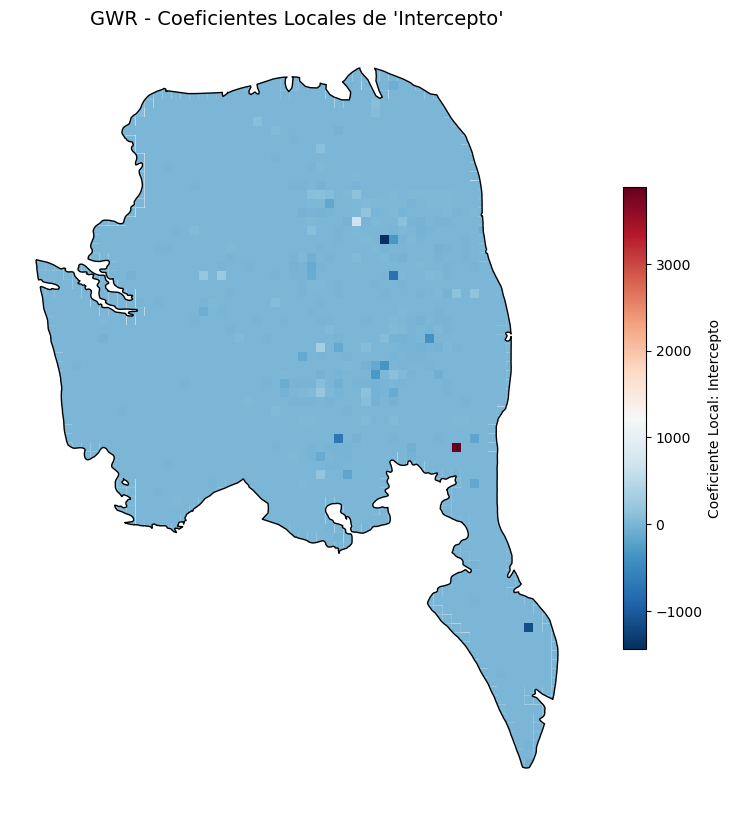

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_Intercepto_coef.png


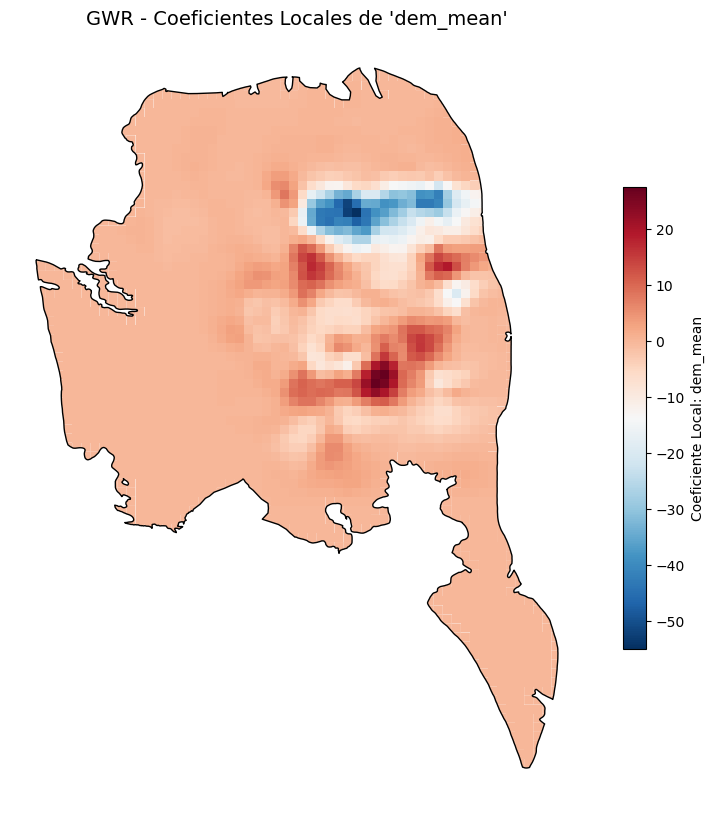

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_dem_mean_coef.png


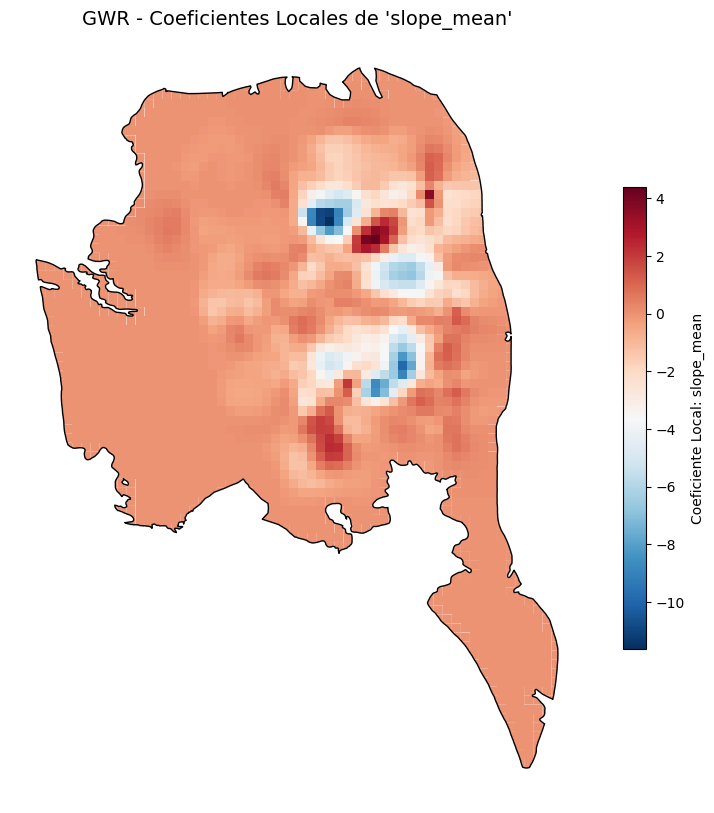

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_slope_mean_coef.png


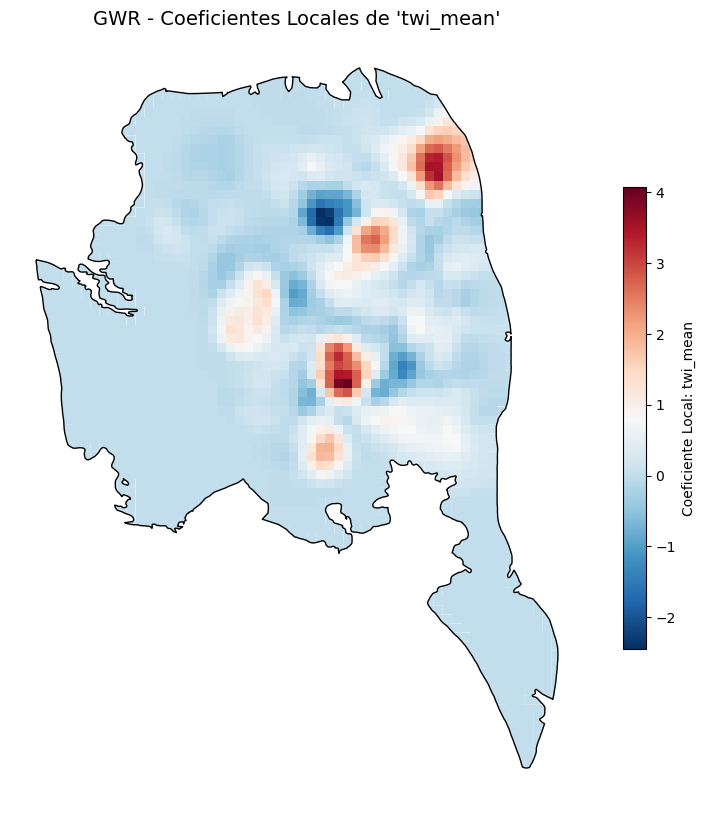

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_twi_mean_coef.png


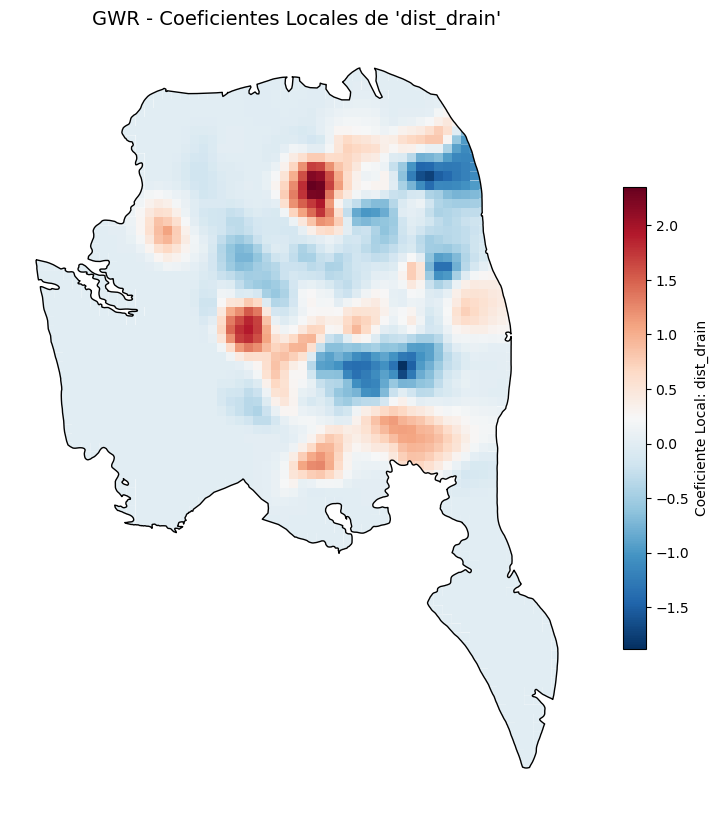

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_dist_drain_coef.png


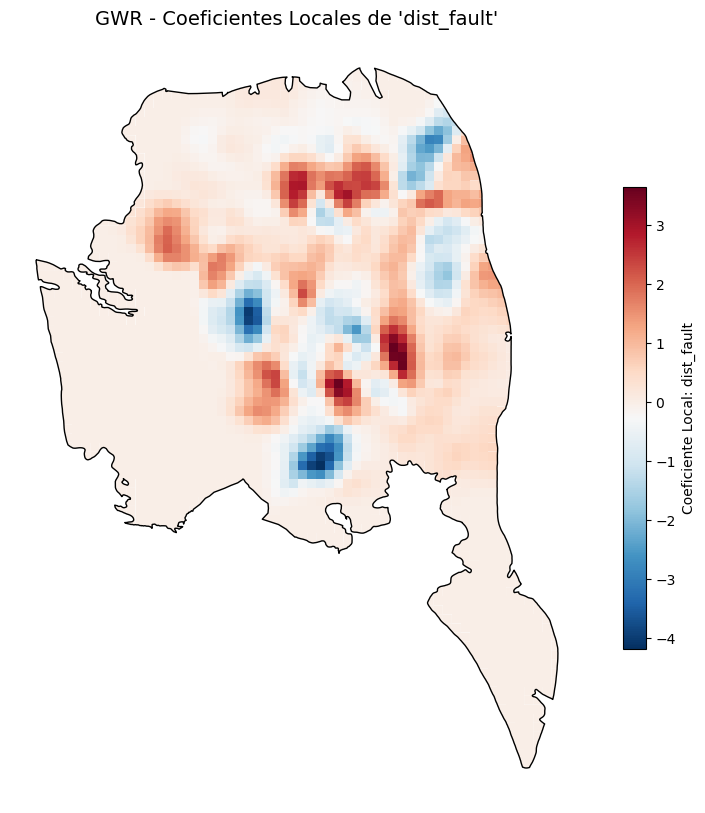

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_dist_fault_coef.png


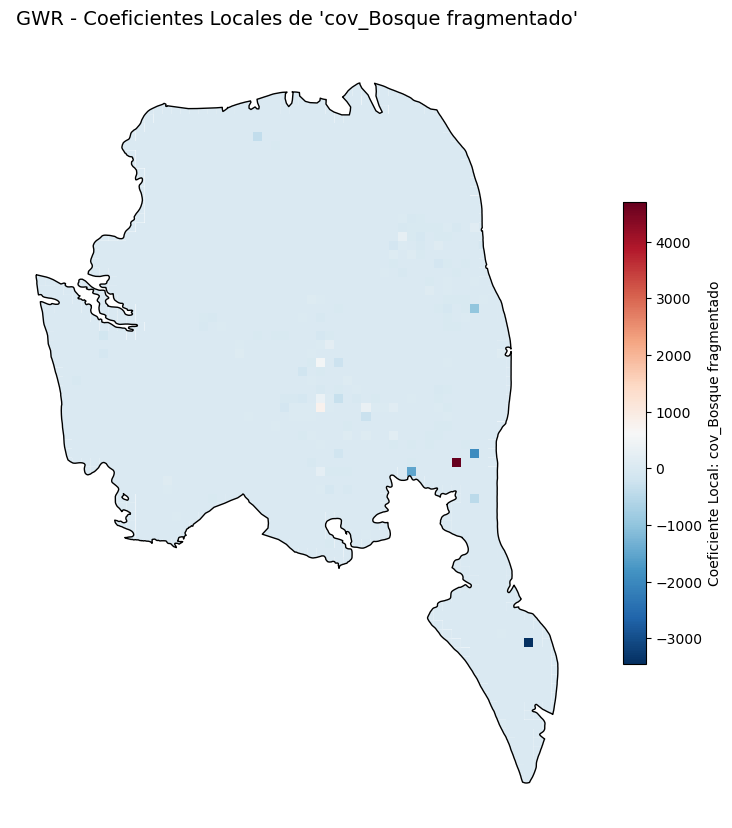

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_cov_Bosque fragmentado_coef.png


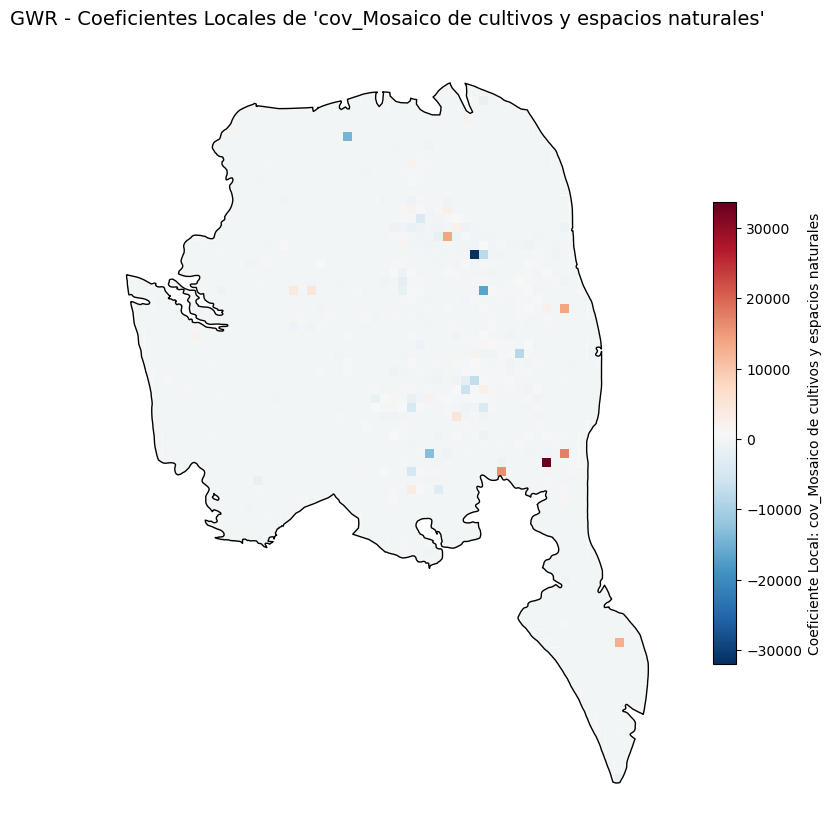

Mapa guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\GWR_maps\GWR_cov_Mosaico de cultivos y espacios naturales_coef.png


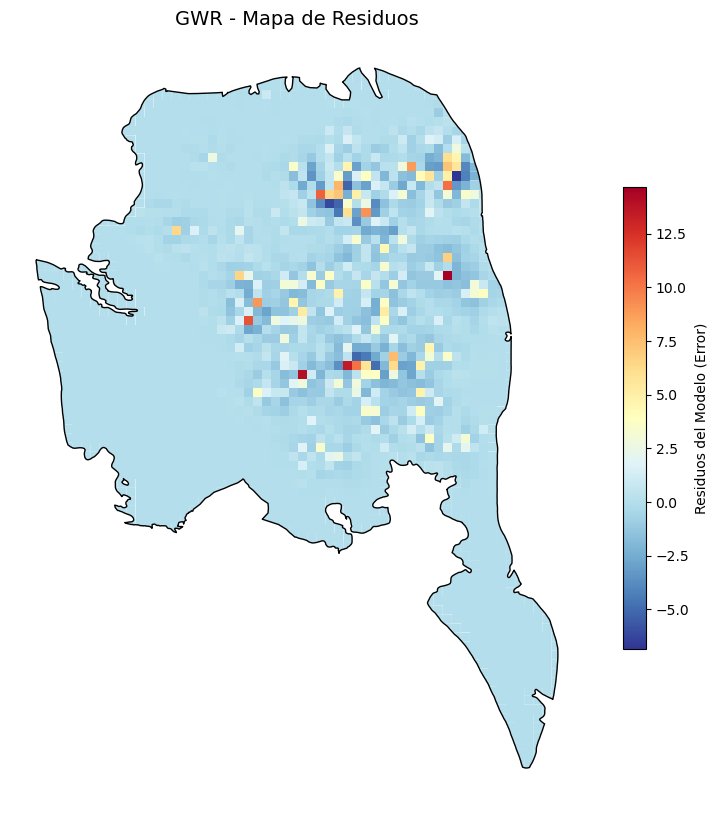

In [3]:
# Mapas modelo

import matplotlib.pyplot as plt
import pandas as pd
import os

nombres_variables = ['Intercepto'] + X_vars # X_vars viene de la celda del modelo

# Crear nombres para las nuevas columnas de coeficientes
columnas_coeficientes = [f"{var}_coef" for var in nombres_variables]

# Crear un DataFrame con los coeficientes
df_coeficientes = pd.DataFrame(model_gwr.params, columns=columnas_coeficientes, index=df_gwr.index)

# Unir los coeficientes
df_gwr = df_gwr.join(df_coeficientes)

# Añadir los residuos
if 'residuos_gwr' not in df_gwr.columns:
    df_gwr['residuos_gwr'] = model_gwr.resid_response.flatten()

# Carpeta de salida para los mapas del GWR 
output_dir     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"
output_dir_gwr_maps = os.path.join(output_dir, 'GWR_maps')
os.makedirs(output_dir_gwr_maps, exist_ok=True)


# Mapa coeficiente Local

for coef_col in columnas_coeficientes:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Usamos un mapa de color divergente para ver fácilmente valores positivos y negativos
    df_gwr.plot(
        column=coef_col,
        cmap='RdBu_r', 
        legend=True,
        edgecolor='none',
        linewidth=0,
        ax=ax,
        legend_kwds={
            'label': f"Coeficiente Local: {coef_col.replace('_coef', '')}",
            'shrink': 0.6
        }
    )

    if 'gdf_contour' in locals():
        gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

    ax.set_title(f"GWR - Coeficientes Locales de '{coef_col.replace('_coef', '')}'", fontsize=14)
    ax.set_axis_off()

    
    output_path = os.path.join(output_dir_gwr_maps, f"GWR_{coef_col}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Mapa guardado en: {output_path}")


# Mapa residuos del modelo

fig, ax = plt.subplots(figsize=(10, 10))

df_gwr.plot(
    column='residuos_gwr',
    cmap='RdYlBu_r',
    legend=True,
    edgecolor='none',
    linewidth=0,
    ax=ax,
    legend_kwds={
        'label': "Residuos del Modelo (Error)",
        'shrink': 0.6
    }
)

if 'gdf_contour' in locals():
    gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

ax.set_title("GWR - Mapa de Residuos", fontsize=14)
ax.set_axis_off()


output_path_res = os.path.join(output_dir_gwr_maps, "GWR_residuos.png")
plt.savefig(output_path_res, dpi=300, bbox_inches='tight')
plt.show()